In [1]:
## 1. Import libs

In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


## 2. Data preprocess

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 4:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


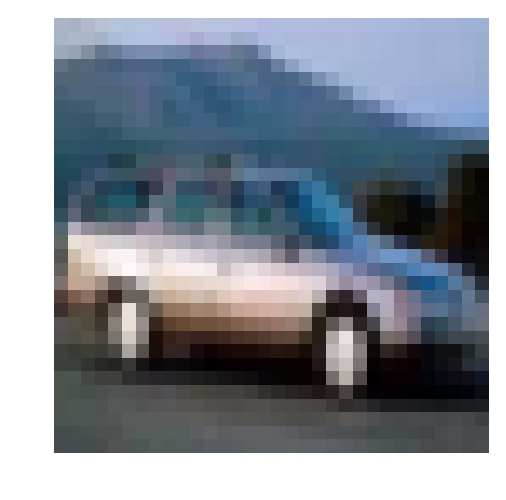

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 4
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [6]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x/255.0


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


In [7]:
from sklearn import preprocessing

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    lb = preprocessing.LabelBinarizer()
    labels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    lb.fit(labels)
    one_hot = lb.transform(x)
    return one_hot


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [10]:
print(test_features.shape)
print(test_labels.shape)
print(valid_features.shape)
print(valid_labels.shape)

(10000, 32, 32, 3)
(10000, 10)
(5000, 32, 32, 3)
(5000, 10)


## 3. Build model

In [19]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu',
                 input_shape = (32, 32, 3)))
# model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

## 4. Train and cross validate model

In [20]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [22]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [24]:
hist = model.fit_generator(datagen.flow(test_features, test_labels, batch_size=16),
                           steps_per_epoch=500,
                           epochs=30, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(valid_features[:400,:], valid_labels[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/30
17s - loss: 1.6818 - acc: 0.2667 - val_loss: 1.4770 - val_acc: 0.3200
Epoch 2/30
17s - loss: 1.5168 - acc: 0.3406 - val_loss: 1.3683 - val_acc: 0.4150
Epoch 3/30
17s - loss: 1.3907 - acc: 0.3921 - val_loss: 1.2358 - val_acc: 0.4225
Epoch 4/30
17s - loss: 1.3196 - acc: 0.4278 - val_loss: 1.1870 - val_acc: 0.4550
Epoch 5/30
18s - loss: 1.2625 - acc: 0.4450 - val_loss: 1.1646 - val_acc: 0.4300
Epoch 6/30
17s - loss: 1.2106 - acc: 0.4612 - val_loss: 1.0934 - val_acc: 0.4825
Epoch 7/30
18s - loss: 1.1943 - acc: 0.4736 - val_loss: 1.1202 - val_acc: 0.4775
Epoch 8/30
17s - loss: 1.1564 - acc: 0.4966 - val_loss: 1.0317 - val_acc: 0.5225
Epoch 9/30
18s - loss: 1.1139 - acc: 0.5068 - val_loss: 1.0461 - val_acc: 0.5400
Epoch 10/30
17s - loss: 1.0846 - acc: 0.5125 - val_loss: 1.0188 - val_acc: 0.4975
Epoch 11/30
17s - loss: 1.0580 - acc: 0.5192 - val_loss: 1.0257 - val_acc: 0.5350
Epoch 12/30
17s - loss: 1.0306 - acc: 0.5449 - val_loss: 0.9690 - val_acc: 0.5450
Epoch 13/30
17s - loss: 1

**网络并不是单纯的网络单层节点越多越好，或者网络层数越多越好。一定的问题复杂度，需要一定规模的和结构的网络。**

## 5. Test model

In [25]:
final_loss, final_acc = model.evaluate(valid_features[400:], valid_labels[400:], verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.8491, final accuracy: 0.6096


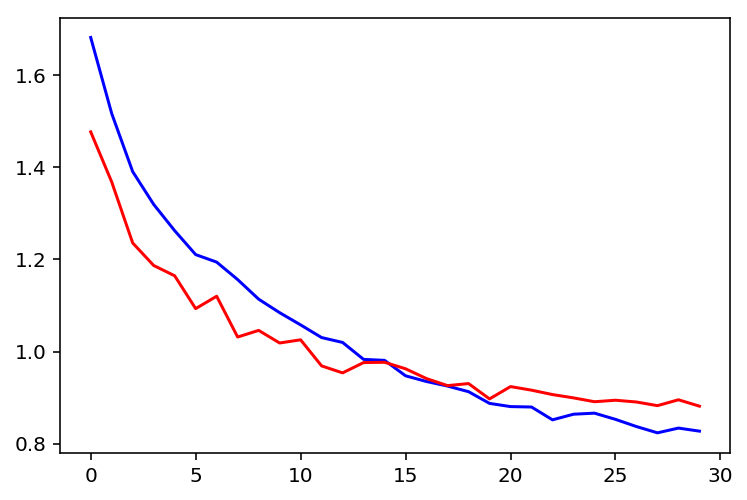

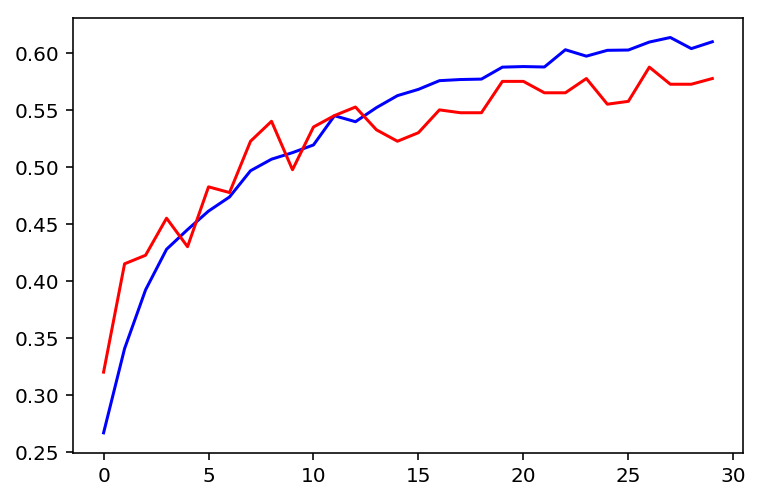

In [26]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()